### Generalized Inverse Filter

In [76]:
% matplotlib inline
import numpy as np
from scipy import signal
import scipy.fftpack as fp
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import random_noise
import matplotlib.pylab as plt
from skimage.measure import compare_psnr
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def inverse_filter(y, h, gamma):
    n = 1 / gamma
    Hf = fp.fft2(fp.ifftshift(h))
    Hf[(np.abs(Hf)<n)] = n
    Hf = np.ones((M,N)) / Hf
    plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Hf))), cmap='coolwarm'), plt.title('Inverse Kernel (FFT)', size=20), plt.colorbar()
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return im

def plot_freq_spec_3d(freq):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    Y = np.arange(-freq.shape[0]//2,freq.shape[0]-freq.shape[0]//2)
    X = np.arange(-freq.shape[1]//2,freq.shape[1]-freq.shape[1]//2)
    X, Y = np.meshgrid(X, Y)
    Z = (20*np.log10( 0.01 + fp.fftshift(freq))).real

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,
                           linewidth=0, antialiased=True)
    #ax.plot_wireframe(X, Y, Z, rstride=20, cstride=20)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    plt.show()

### With Gaussian Blur Kernel

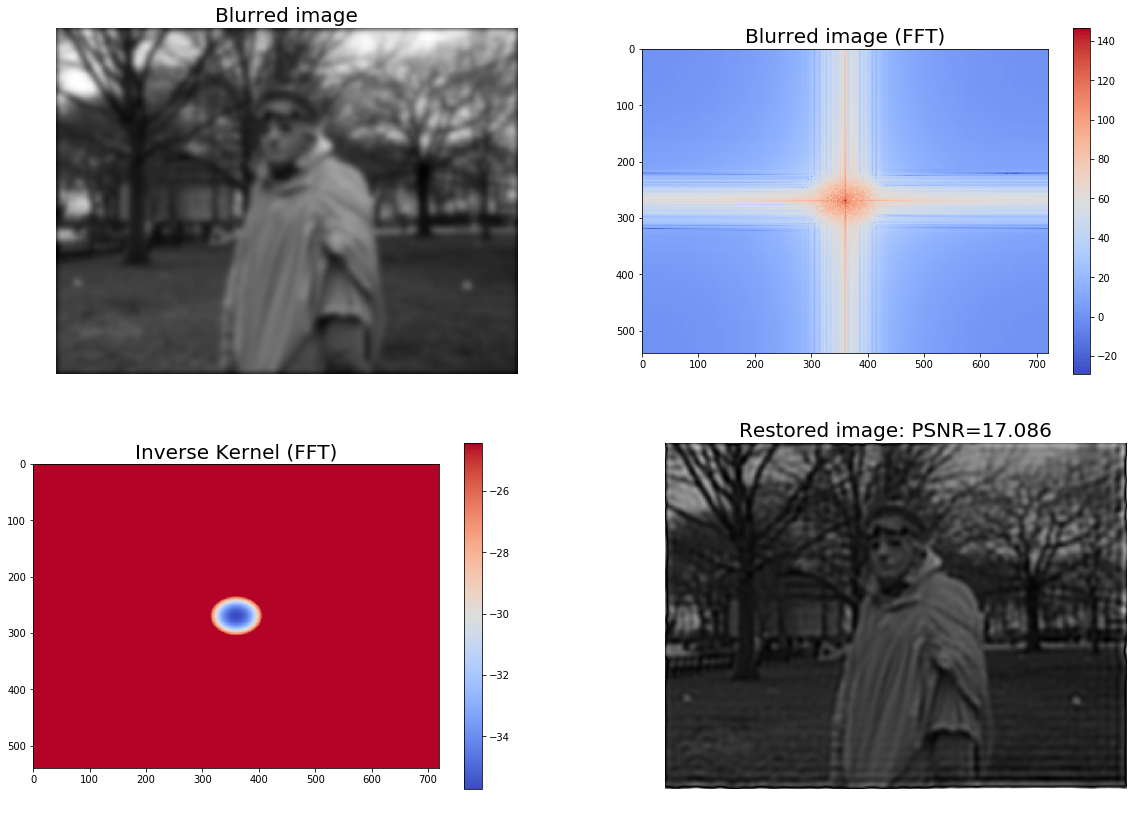

PSNR (Inverse): 17.086442692188495


In [77]:
im = rgb2gray(imread('images/statue.jpg'))
(M, N), k, sigma2 = im.shape, 31, 5
kernel = np.outer(signal.gaussian(k, sigma2), signal.gaussian(k, sigma2))
im_blur = signal.convolve2d(im, kernel, mode='same')
im_cor = im_blur

plt.figure(figsize=(20,14))
plt.gray()

plt.subplot(221), plt.imshow(im_cor), plt.title('Blurred image', size=20), plt.axis('off')

freq = fp.fft2(im_cor)

plt.subplot(222), plt.imshow( (20*np.log10( 0.01 + fp.fftshift(freq))).real, cmap='coolwarm'), plt.title('Blurred image (FFT)', size=20), plt.colorbar()

gamma = 0.05
plt.subplot(223)
kernel = np.pad(kernel, (((M-k)//2,(M-k)//2+1), ((N-k)//2,(N-k)//2+1)), mode='constant')
im_res = inverse_filter(im_cor, kernel, gamma)

plt.subplot(224), plt.imshow(im_res), plt.title('Restored image: PSNR={:.3f}'.format(compare_psnr(im, im_res)), size=20), plt.axis('off')

plt.show()

print('PSNR (Inverse): {}'.format(compare_psnr(im, im_res)))

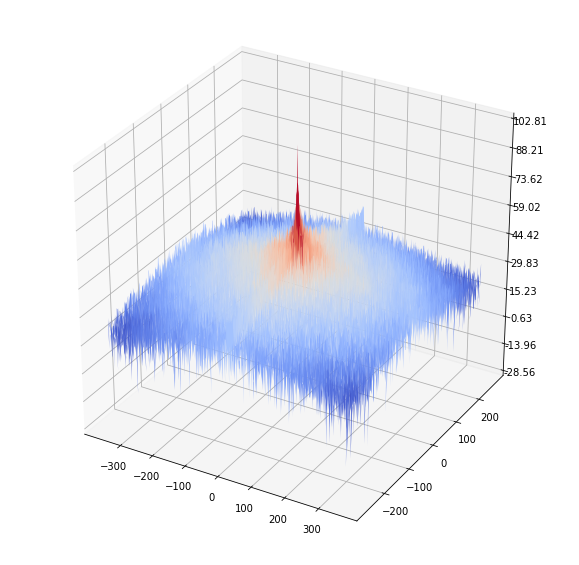

In [78]:
plot_freq_spec_3d(fp.fft2(im))

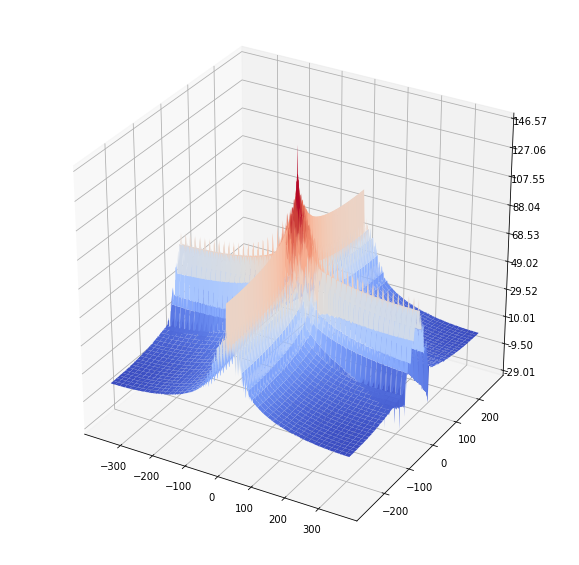

In [79]:
plot_freq_spec_3d(fp.fft2(im_blur))

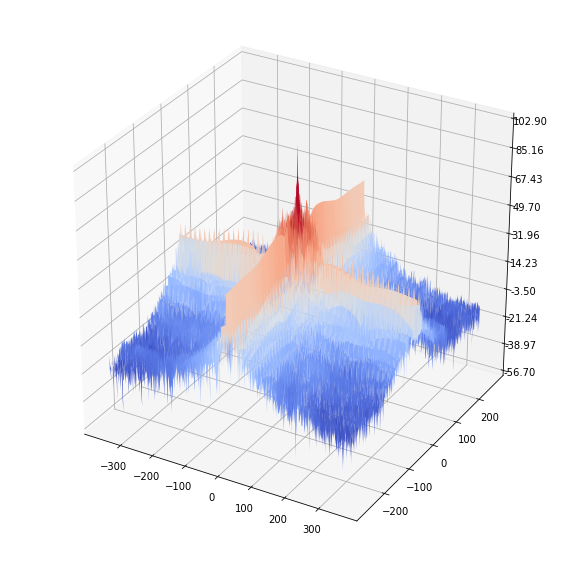

In [80]:
plot_freq_spec_3d(fp.fft2(im_res))

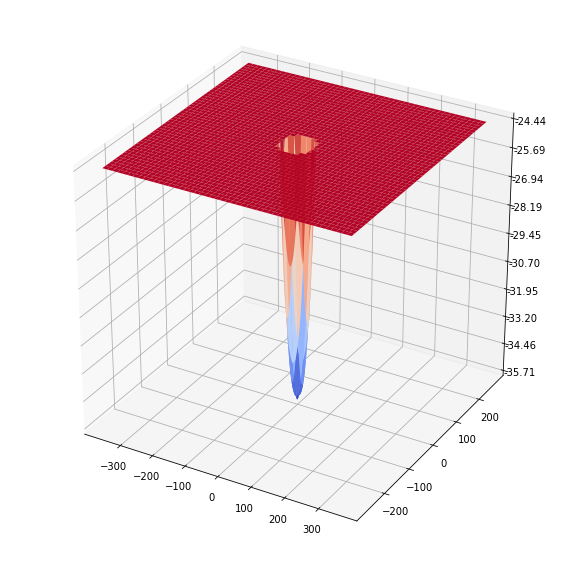

In [81]:
freq_kernel = fp.fft2(fp.ifftshift(kernel))
freq_kernel[(np.abs(freq_kernel)<1/gamma)] = 1/gamma
freq_kernel = np.ones((M,N)) / freq_kernel
plot_freq_spec_3d(freq_kernel)

### With Noise

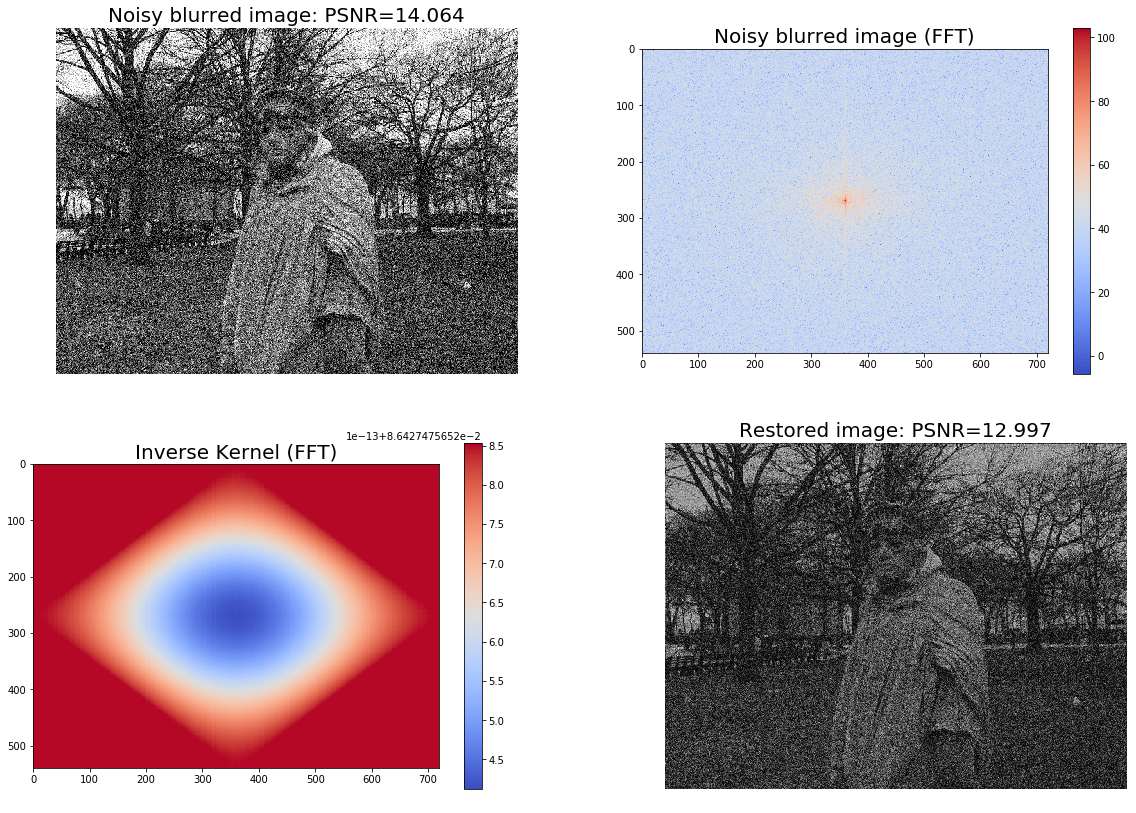

PSNR (Noisy): 14.064448557839516
PSNR (Inverse): 12.996582132189122


In [84]:
im = rgb2gray(imread('images/statue.jpg')) 
(M, N), k, sigma2, nsigma2 = im.shape, 11, 0.125, 0.05
kernel = np.outer(signal.gaussian(k, sigma2), signal.gaussian(k, sigma2))
im_blur = signal.convolve2d(im, kernel, mode='same')
im_cor = random_noise(im_blur, var=nsigma2)

plt.figure(figsize=(20,14))
plt.gray()

plt.subplot(221), plt.imshow(im_cor), plt.title('Noisy blurred image: PSNR={:.3f}'.format(compare_psnr(im, im_cor)), size=20), plt.axis('off')

freq = fp.fft2(im_cor)

plt.subplot(222), plt.imshow( (20*np.log10( 0.01 + fp.fftshift(freq))).real, cmap='coolwarm'), plt.title('Noisy blurred image (FFT)', size=20), plt.colorbar()

gamma = 1
plt.subplot(223)
kernel = np.pad(kernel, (((M-k)//2,(M-k)//2+1), ((N-k)//2,(N-k)//2+1)), mode='constant')
im_res = inverse_filter(im_cor, kernel, gamma)

plt.subplot(224), plt.imshow(im_res), plt.title('Restored image: PSNR={:.3f}'.format(compare_psnr(im, im_res)), size=20), plt.axis('off')

plt.show()

print('PSNR (Noisy): {}'.format(compare_psnr(im, im_cor)))
print('PSNR (Inverse): {}'.format(compare_psnr(im, im_res)))

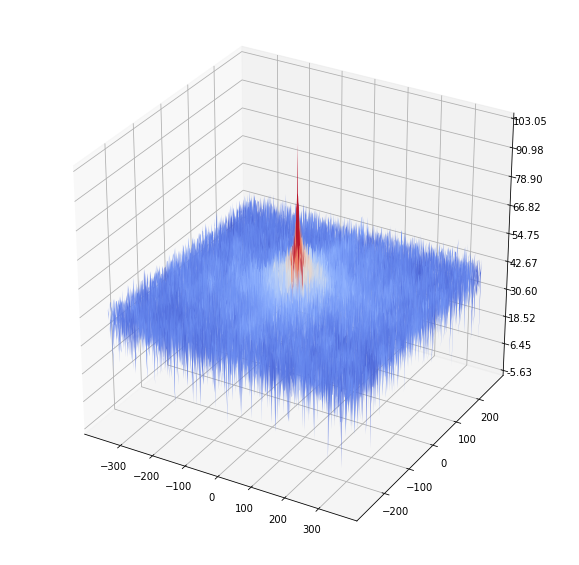

In [86]:
plot_freq_spec_3d(fp.fft2(im_cor))

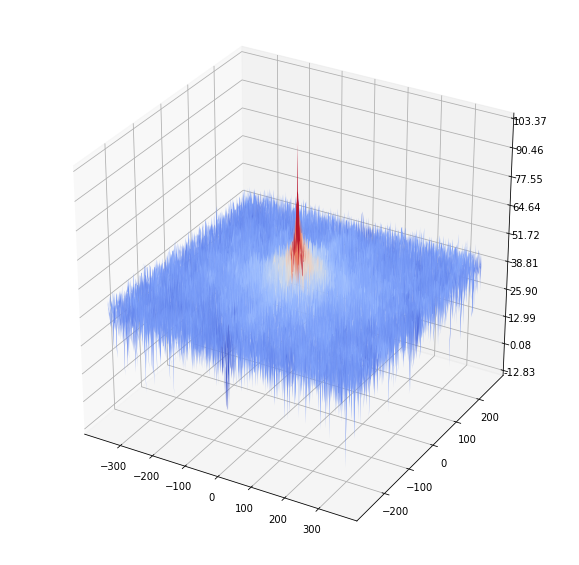

In [87]:
plot_freq_spec_3d(fp.fft2(im_res))

### Motion Blur Kernel

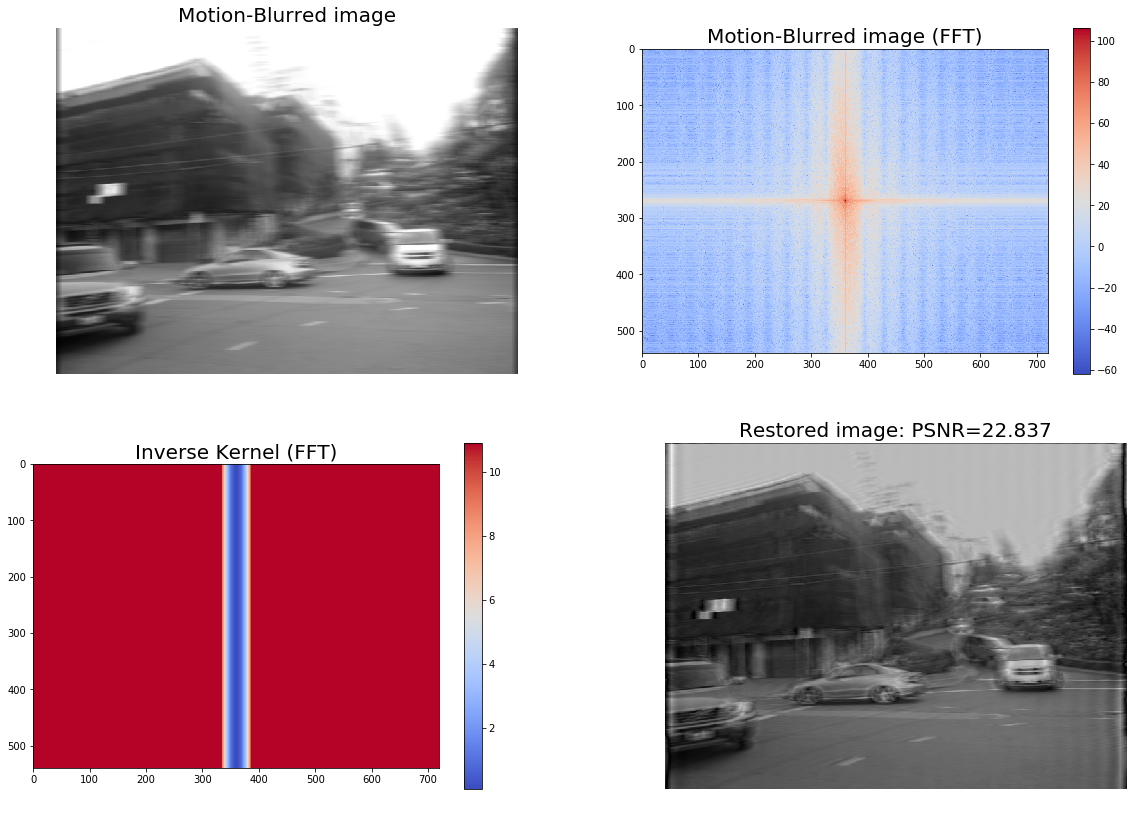

PSNR (Inverse): 22.8366419785816


In [94]:
im = rgb2gray(imread('images/street.jpg'))
(M, N), k = im.shape, 21 # a 21 x 21 motion blurred kernel
kernel = np.zeros((k, k))
kernel[int((k-1)/2), :] = np.ones(k)
kernel = kernel / k
im_blur = signal.convolve2d(im, kernel, mode='same')
im_cor = im_blur

plt.figure(figsize=(20,14))
plt.gray()

plt.subplot(221), plt.imshow(im_cor), plt.title('Motion-Blurred image', size=20), plt.axis('off')

freq = fp.fft2(im_cor)

plt.subplot(222), plt.imshow( (20*np.log10( 0.01 + fp.fftshift(freq))).real, cmap='coolwarm'), plt.title('Motion-Blurred image (FFT)', size=20), plt.colorbar()

gamma = 3.5
plt.subplot(223)
# expand the kernel by padding zeros
kernel = np.pad(kernel, (((M-k)//2,(M-k)//2+1), ((N-k)//2,(N-k)//2+1)), mode='constant')
im_res = inverse_filter(im_cor, kernel, gamma)

plt.subplot(224), plt.imshow(im_res), plt.title('Restored image: PSNR={:.3f}'.format(compare_psnr(im, im_res)), size=20), plt.axis('off')

plt.show()

print('PSNR (Inverse): {}'.format(compare_psnr(im, im_res)))

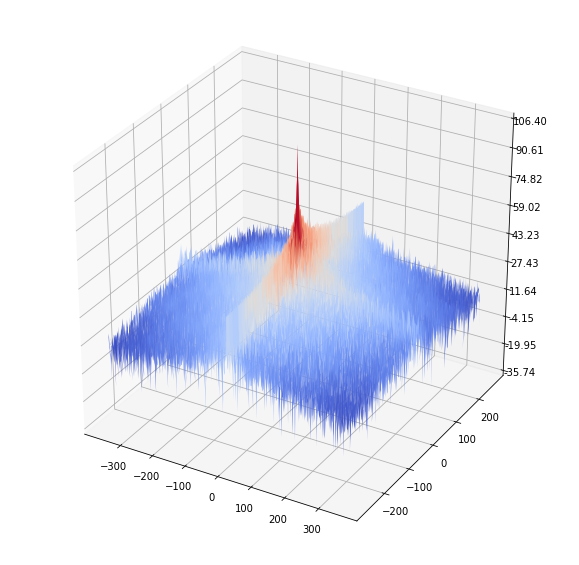

In [95]:
plot_freq_spec_3d(fp.fft2(im))

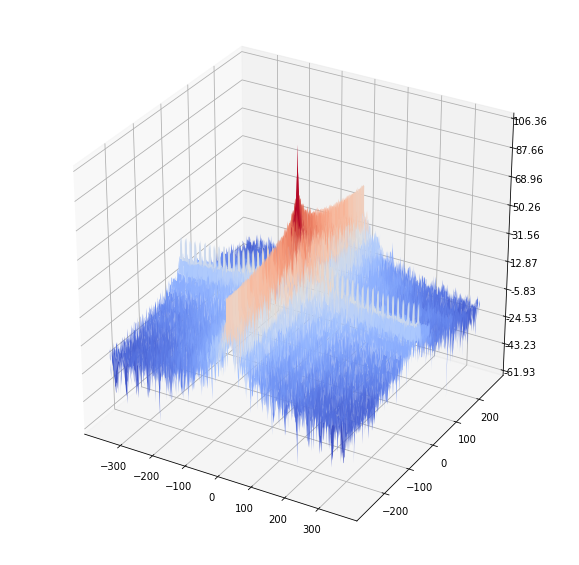

In [96]:
plot_freq_spec_3d(fp.fft2(im_blur))

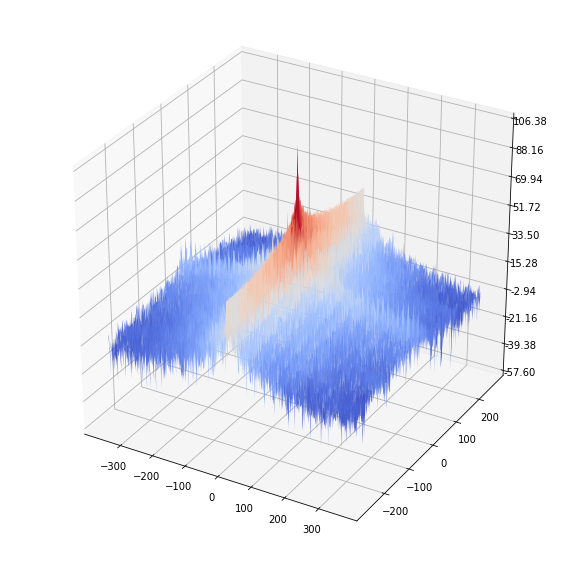

In [97]:
plot_freq_spec_3d(fp.fft2(im_res))

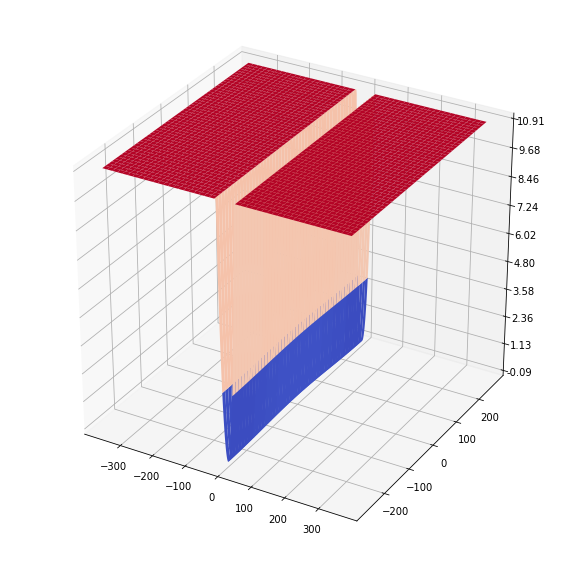

In [98]:
freq_kernel = fp.fft2(fp.ifftshift(kernel))
freq_kernel[(np.abs(freq_kernel)<1/gamma)] = 1/gamma
freq_kernel = np.ones((M,N)) / freq_kernel
plot_freq_spec_3d(freq_kernel)

### Wiener Filter

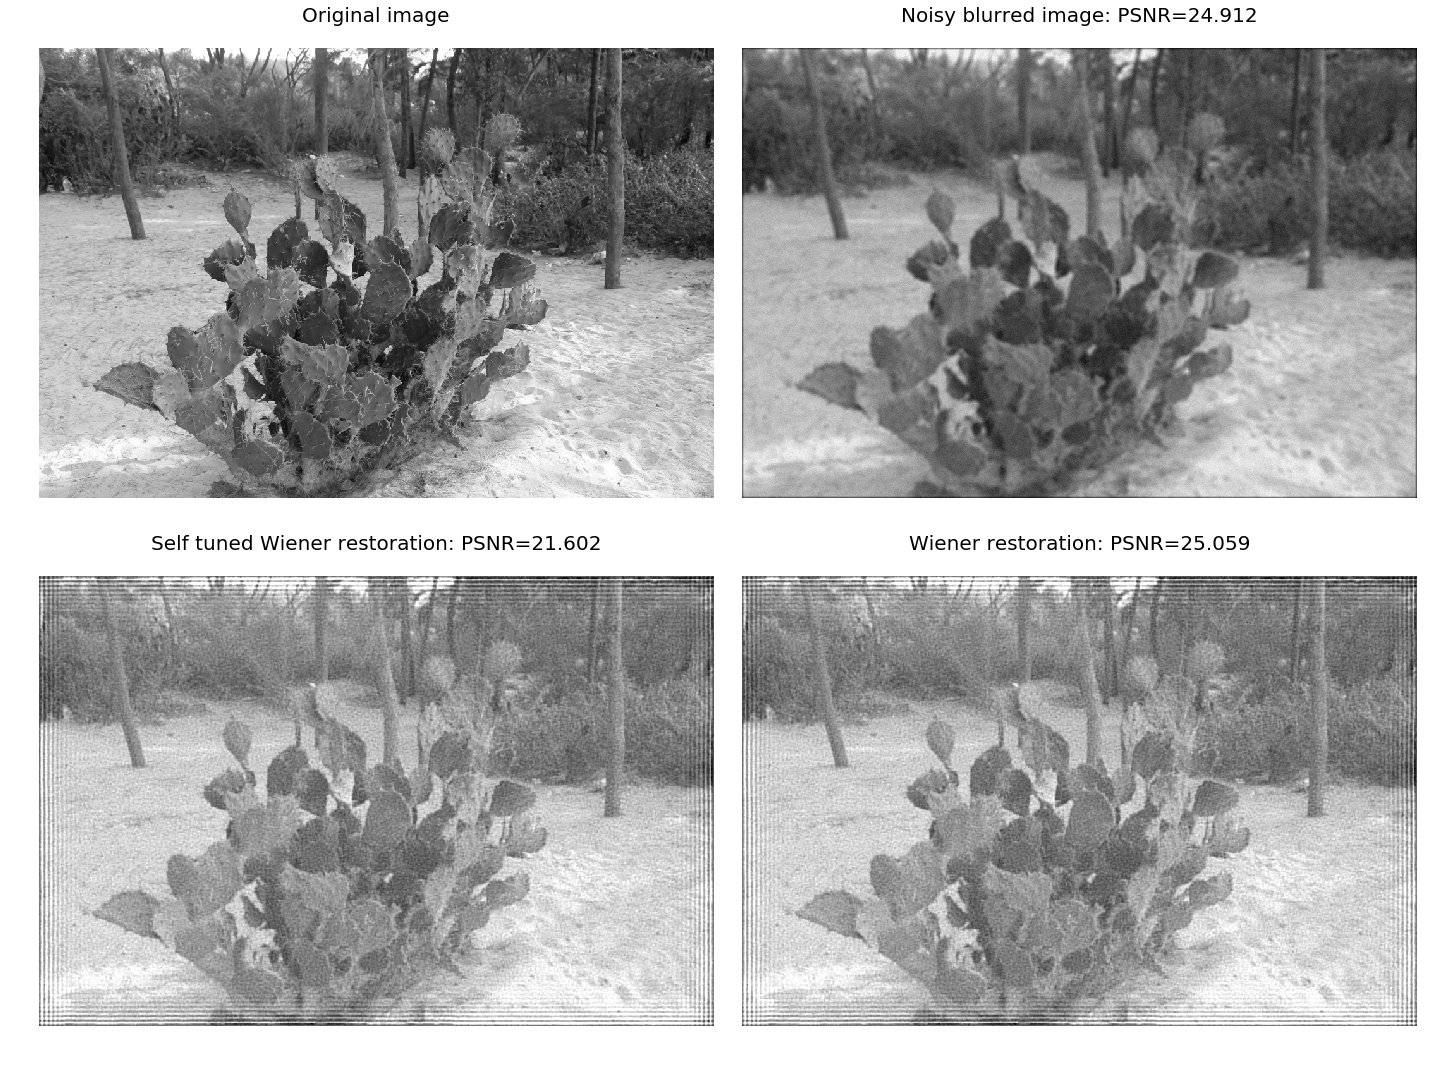

In [99]:
from skimage import color, data, restoration
im = color.rgb2gray(imread('images/cactus.jpg'))
from scipy.signal import convolve2d as conv2
n = 7
psf = np.ones((n, n)) / n**2
im1 = conv2(im, psf, 'same')
im1 += 0.1 * im.std() * np.random.standard_normal(im.shape)
im2, _ = restoration.unsupervised_wiener(im1, psf)
im3 = restoration.wiener(im1, psf, balance=0.1)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), sharex=True, sharey=True)
plt.gray()
axes[0,0].imshow(im), axes[0,0].axis('off'), axes[0,0].set_title('Original image', size=20)
axes[0,1].imshow(im1), axes[0,1].axis('off'), axes[0,1].set_title('Noisy blurred image: PSNR={:.3f}'.format(compare_psnr(im, im1)), size=20)
axes[1,0].imshow(im2), axes[1,0].axis('off'), axes[1,0].set_title('Self tuned Wiener restoration: PSNR={:.3f}'.format(compare_psnr(im, im2)), size=20)
axes[1,1].imshow(im2), axes[1,1].axis('off'), axes[1,1].set_title('Wiener restoration: PSNR={:.3f}'.format(compare_psnr(im, im3)), size=20)
fig.tight_layout()
plt.show()

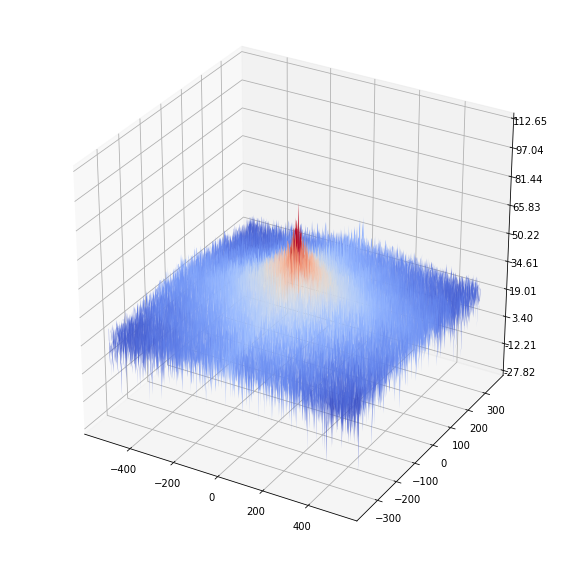

In [100]:
plot_freq_spec_3d(fp.fft2(im))

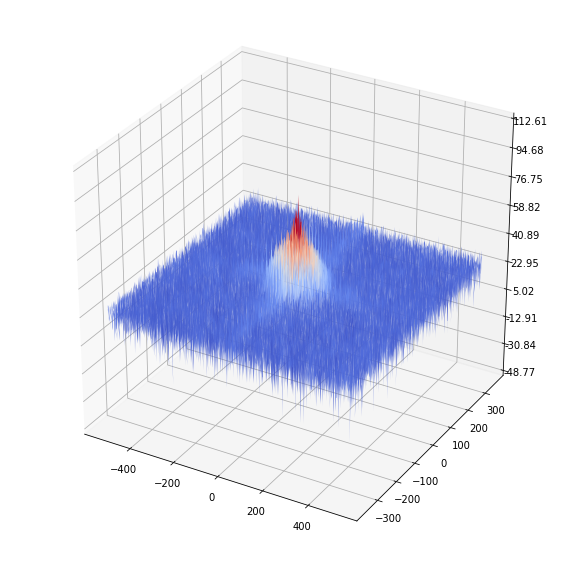

In [101]:
plot_freq_spec_3d(fp.fft2(im1))

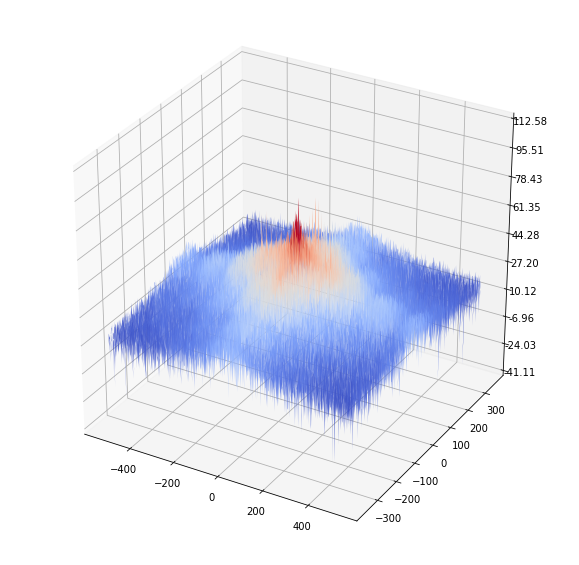

In [102]:
plot_freq_spec_3d(fp.fft2(im2))

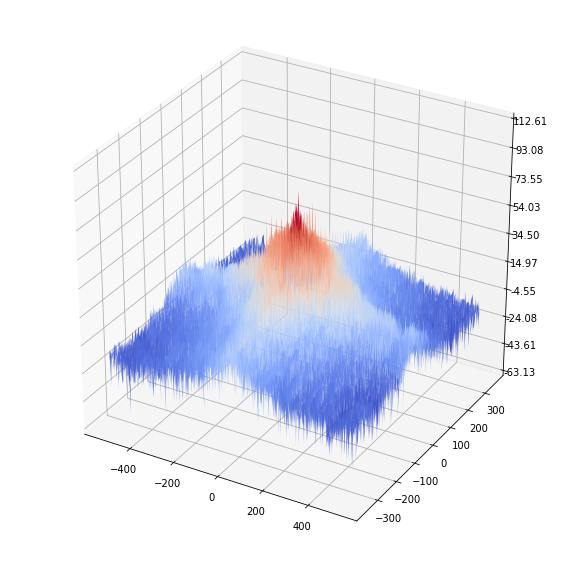

In [103]:
plot_freq_spec_3d(fp.fft2(im3))

### Constrained Least Squares (CLS) Filter

(720, 540)
1.0


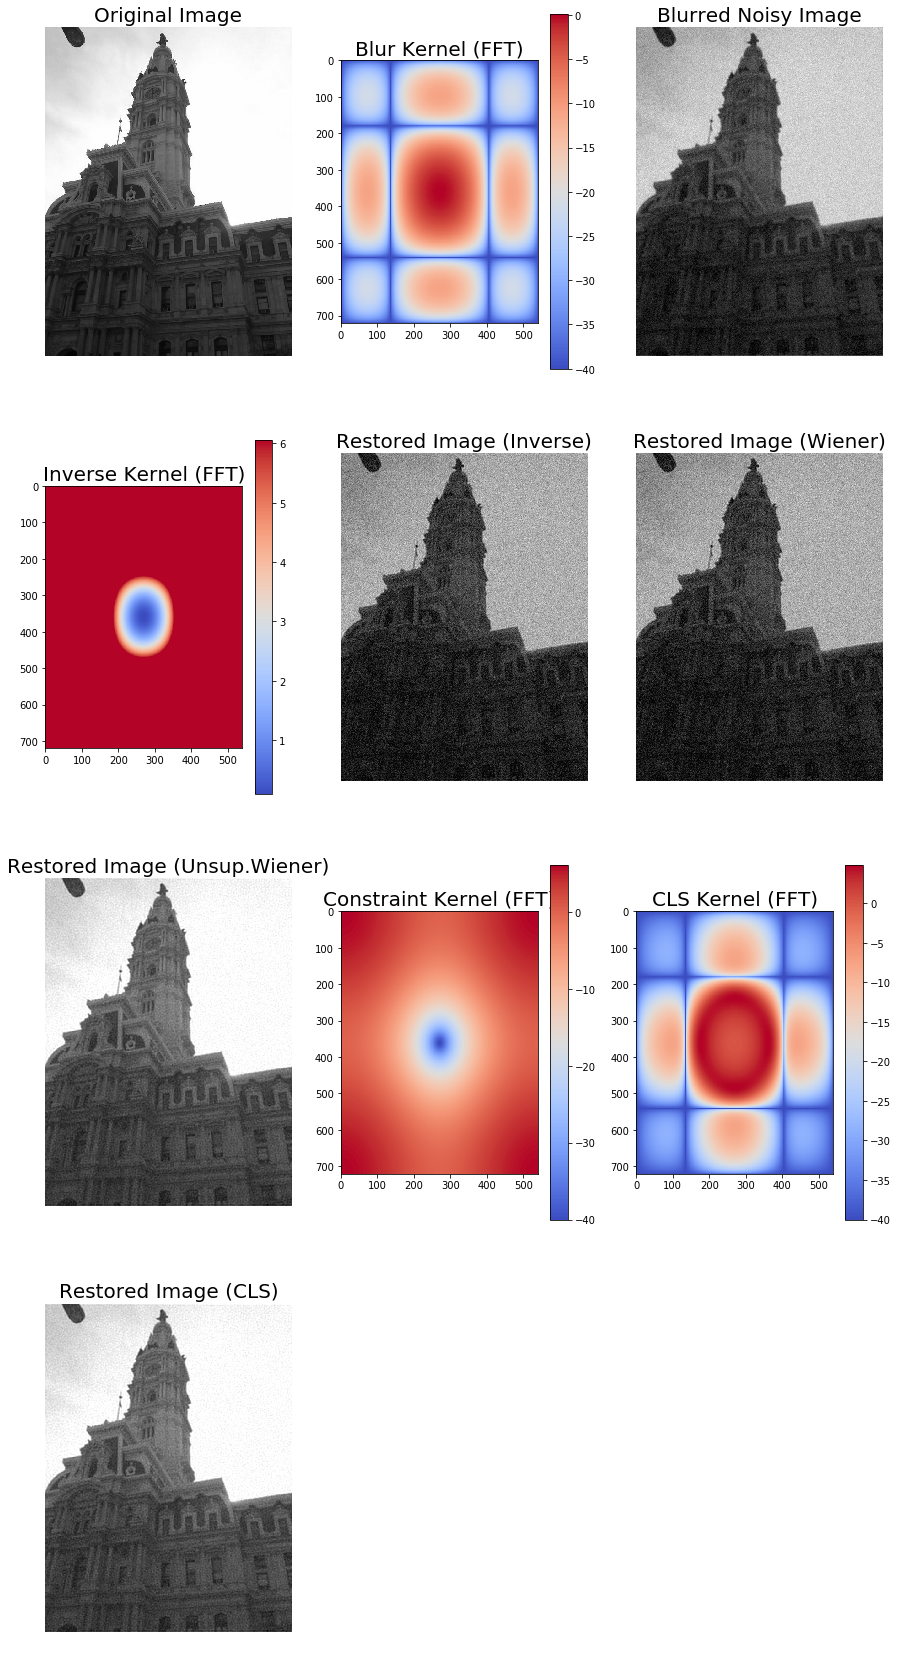

PSNR (Noisy): 24.590248769145774
PSNR (Inverse): 20.163450988283856
PSNR (Wiener): 29.38871236574107
PSNR (Unsup. Wiener): 28.56182429716791
PSNR (CLS): 28.58479160818092


In [104]:
import numpy as np
import scipy.fftpack as fp
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.restoration import wiener, unsupervised_wiener
from skimage.measure import compare_psnr
import matplotlib.pylab as plt

def cls_filter(y,h,c,alpha):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf = np.conj(Hf) / (Hf*np.conj(Hf) + alpha*Cf*np.conj(Cf))
    plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Hf))), cmap='coolwarm'), plt.title('CLS Kernel (FFT)', size=20), plt.colorbar()
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return im 


# Input and display the binary image
lambd = 0.1
x = rgb2gray(imread('images/building.jpg'))
print(x.shape)
M, N = x.shape
print(np.max(x))

plt.figure(figsize=(15,30))

plt.subplot(431), plt.imshow(x, cmap='gray'), plt.axis('off'), plt.title('Original Image', size=20)

# Blur the image, corrupt the image using WGN and display it
# h is the blurring filter, and sigma is the noise std
h = np.ones((4,4))/16
h = np.pad(h, [(M//2-2, M//2-2), (N//2-2, N//2-2)], mode='constant')
sigma = 0.05
Xf = fp.fft2(x)
Hf = fp.fft2(fp.ifftshift(h))

plt.subplot(432), plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Hf))), cmap='coolwarm'), plt.title('Blur Kernel (FFT)', size=20), plt.colorbar()

Y = Hf*Xf
y = fp.ifft2(Y).real + sigma*np.random.normal(size=(M,N))

plt.subplot(433), plt.imshow(np.abs(y), cmap='gray'), plt.axis('off'), plt.title('Blurred Noisy Image', size=20)

# restoration using inverse filtering
gamma = 2
plt.subplot(434)
eix = inverse_filter(y, h, gamma)
plt.subplot(435), plt.imshow(eix, cmap='gray'), plt.axis('off'), plt.title('Restored Image (Inverse)', size=20)

# restoration using wiener filtering
ewx = wiener(y, h, balance=0.1)
plt.subplot(436), plt.imshow(eix, cmap='gray'), plt.axis('off'), plt.title('Restored Image (Wiener)', size=20)

# restoration using unsupervised wiener filtering
euwx, _ = unsupervised_wiener(y, h)
plt.subplot(437), plt.imshow(euwx, cmap='gray'), plt.axis('off'), plt.title('Restored Image (Unsup.Wiener)', size=20)

# restoration using cls filtering
alpha = 1
c =  np.array([[0,1/4,0],[1/4,-1,1/4],[0,1/4,0]])
c = np.pad(c, [(M//2-1, M//2-2), (N//2-2, N//2-1)], mode='constant')

Cf = fp.fft2(fp.ifftshift(c))
plt.subplot(438), plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Cf))), cmap='coolwarm'), plt.title('Constraint Kernel (FFT)', size=20), plt.colorbar()

plt.subplot(439)
clx = cls_filter(y, h, c, alpha)

plt.subplot(4,3,10), plt.imshow(euwx, cmap='gray'), plt.axis('off'), plt.title('Restored Image (CLS)', size=20)

plt.show()

print('PSNR (Noisy): {}'.format(compare_psnr(x, y)))
print('PSNR (Inverse): {}'.format(compare_psnr(x, eix)))
print('PSNR (Wiener): {}'.format(compare_psnr(x, ewx)))
print('PSNR (Unsup. Wiener): {}'.format(compare_psnr(x, euwx)))
print('PSNR (CLS): {}'.format(compare_psnr(x, clx)))

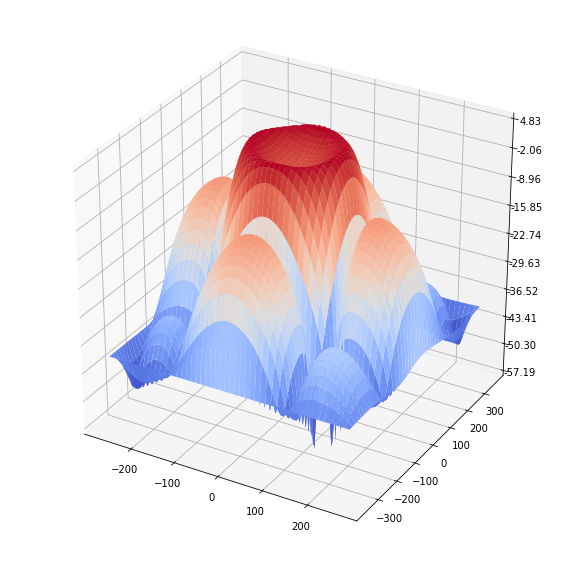

In [106]:
freq_kernel = np.conj(Hf) / (Hf*np.conj(Hf) + alpha*Cf*np.conj(Cf))      
plot_freq_spec_3d(freq_kernel)

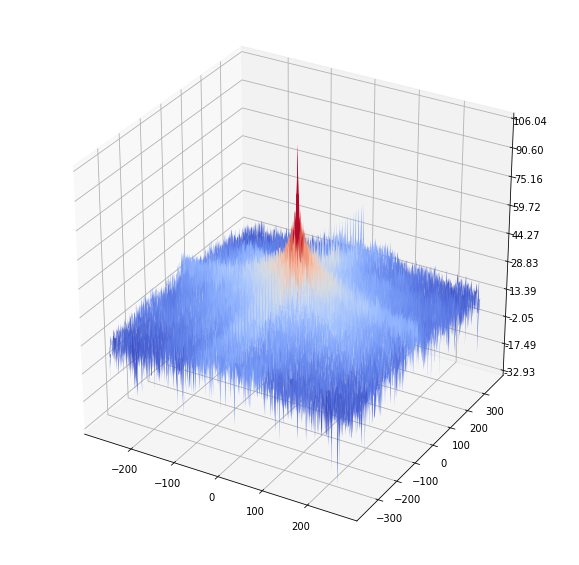

In [107]:
plot_freq_spec_3d(fp.fft2(x))

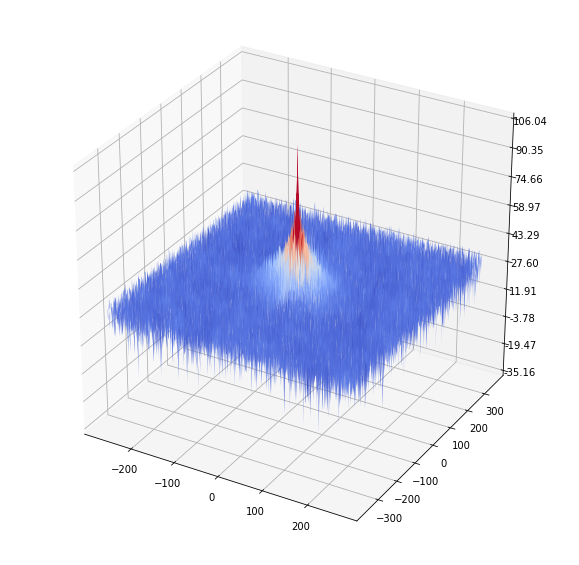

In [108]:
plot_freq_spec_3d(fp.fft2(y))

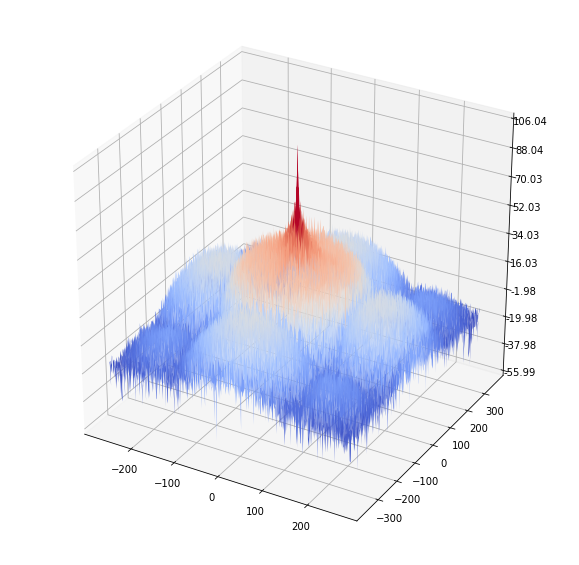

In [109]:
plot_freq_spec_3d(fp.fft2(clx))

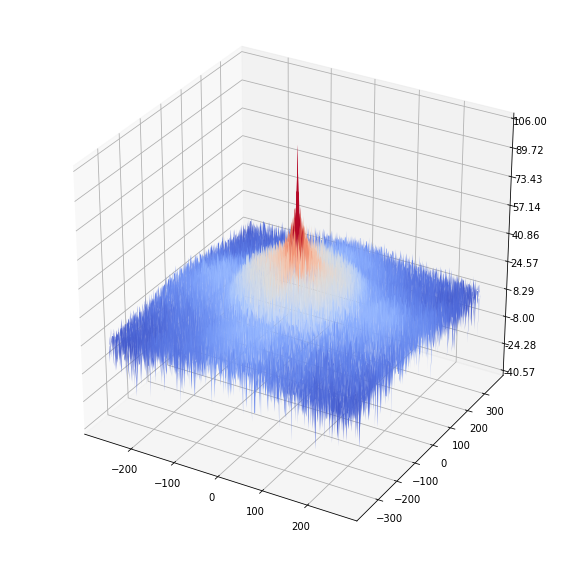

In [110]:
plot_freq_spec_3d(fp.fft2(euwx))